In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mplt
import camb
from camb import model, initialpower
from camb.sources import GaussianSourceWindow, SplinedSourceWindow
import pickle
import scipy
from scipy.interpolate import splrep, splev, spalde
from scipy.optimize import curve_fit
from scipy.integrate import *
from scipy.special import erf
import time
import multiprocessing as mp
from multiprocessing import Pool
import pandas as pd
import seaborn as sns
sns.color_palette('colorblind')
sns.set_palette('colorblind')
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)
pars.InitPower.set_params(As=2e-9, ns=0.965)
lmax=2000
pars.set_for_lmax(lmax, lens_potential_accuracy=1)
pars.Want_CMB = False
pars.NonLinear = model.NonLinear_both
ls= np.arange(2, lmax+1)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "cm"})
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]


/tmp/ipykernel_425/2757883804.py:31: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]


In [2]:
### parameterisation of the bias
def bias(z,b,alpha,typ='linear'):
    if typ == 'linear':
        return b*(1+z)**alpha
    elif typ == 'exp':
        return b*np.exp((1+z)**alpha)

### below is the 5-point stencil derivative function
def deriv(h,m2,m1,p1,p2):
    return (m2-8*m1+8*p1-p2)/(12.0*h)

#### now parameterisation of magnification and evolution bias for ET for $\rho_{th} = 8$
#### Can control to switch them on or off using parameter ''on''

s_p_fid = {'s_a':-3.77e-3,'s_b':1.97e-2,'s_c':9.43e-3,'s_d':-1.34e-3}
be_p_fid = {'be_a':-1.46,'be_b':-1.29,'be_c':2.00,'be_d':-3.66e-1}

def s_ET(z,s_p=s_p_fid,on=True):
         #a=-3.77e-3,b=1.97e-2,c=9.43e-3,d=-1.34e-3,on=True):
    if on == True:
        a,b,c,d = [s_p[i] for i in s_p]
        return a+b*z+c*z**2+d*z**3
    else:
        return 0

def be_ET(z,be_p=be_p_fid,on=True):
    if on == True:
        a,b,c,d = [be_p[i] for i in be_p]
        return a+b*z+c*z**2+d*z**3
    else:
        return 0

def s_gal(z,on=True):
    if on == True:
        return float(s_int_gal(z))
    else:
        return 0
    
def be_gal(z,on=True):
    if on == True:
        return float(be_int_gal(z))
    else:
        return 0

In [3]:
### create a dictionary object containing fiducial values
fid = {'b':1,'alpha':1,'s':s_p_fid,'be':be_p_fid}

### Make C$\ell$

In [4]:
#### key function: this function takes a range of redshift as input, and a bin size for the windows (s1). b and alpha are set as
#### standard input, but can be changed when wanting to compute the derivatived wrt to either parameter.
#### The function computes then the Cls for ALL windows combination. Thus we get the Cls for each (i,j) redshift bin.
#### NOTE: there's an extra parameter called mode. This controls whether we want to compute all windows in DL space or if we 
#### want to compute cross-correlation between a tracer in DL space with one in z-space
def make_cls(z_range,s1,s2=0.1,b=1,alpha=1,s_p=s_p_fid,be_p=be_p_fid,mode='Ldist',on=False,lmax=100,typ='linear'):
    
    if mode == 'Ldist':
        pars.SourceWindows = [GaussianSourceWindow(redshift=z1, source_type='Ldist', bias=bias(z1,b,alpha,typ='linear'), 
                                                   sigma=s1,dlog10Ndm=s_ET(z1,s_p=s_p,on=on),
                                                   evo_bias=be_ET(z1,be_p=be_p,on=on)) for z1 in z_range]
    elif mode == 'cross':
        pars.SourceWindows = []
        windows = [(GaussianSourceWindow(redshift=z1,source_type='counts', bias=(1+0.84*z1), 
                                              sigma=s2,dlog10Ndm=s_gal(z1,on=on),evo_bias=be_gal(z1,on=on))) for z1 in z_range]
        for z1 in z_range:
            windows.append(GaussianSourceWindow(redshift=z1, source_type='Ldist', bias=bias(z1,b,alpha), 
                                                sigma=s1,dlog10Ndm=s_ET(z1,s_p=s_p,on=on),
                                                evo_bias=be_ET(z1,be_p=be_p,on=on)))

        pars.SourceWindows = windows

    diction = {'Density':True,'LSD':True,'Lensing':True,'Potentials':True,
           'Time-Delay':True,'Doppler':True,'ISW':True, 'Evo':False}
    pars.SourceTerms.counts_density = diction['Density']
    pars.SourceTerms.counts_redshift = diction['LSD']
    pars.SourceTerms.counts_lensing = diction['Lensing']
    pars.SourceTerms.counts_potential = diction['Potentials']
    pars.SourceTerms.counts_timedelay = diction['Time-Delay']
    pars.SourceTerms.counts_velocity = diction['Doppler']
    pars.SourceTerms.counts_ISW = diction['ISW']
    pars.SourceTerms.counts_evolve_inputbe = True# diction['Evo']
    pars.SourceTerms.counts_evolve = False
    pars.max_l = lmax
    results = camb.get_results(pars)
    return results.get_source_cls_dict(raw_cl=True)



## Make some noise (!!!)

In [5]:
## load in the number densities for GWs computed with a different file
## these are in Gpc^-3 though
from astropy.constants import G, M_sun, c,h
c_speed = c.value/1e3

with open('ET_z_8.pkl', 'rb') as f:
    ET_z_8 = pickle.load(f)
with open('CE_z_8.pkl', 'rb') as f:
    CE_z_8 = pickle.load(f)

def r(zi):
    return results.comoving_radial_distance(zi)
def curlyH(zi):
    return results.h_of_z(zi)/(1+zi)

z_range_ET = np.linspace(0.1,10,num=100)
#### results.hubble_parameter(zi)
pars.Want_CMB = True
results = camb.get_results(pars)
N_ET_full = [ET_z_8(zi)*r(zi)**2/results.hubble_parameter(zi)*c_speed*1e-9 for zi in z_range_ET]
             #**2*c_speed/results.h_of_z(zi)*10**(-9) for zi in z_range_ET] #r and h in Mpc and Mpc-1, but ET_z_8 in Gpc-3!
N_CE_full = [CE_z_8(zi)*r(zi)**2/results.hubble_parameter(zi)*c_speed*1e-9 for zi in z_range_ET]
# c/h *chi**2 *conversion to DL
norm_ET = np.trapz(N_ET_full, z_range_ET)
norm_CE = np.trapz(N_CE_full, z_range_ET)

def func(z,a,b,z0,d):
    return a*(z/z0)**b*np.exp(-(z/z0)**d)

pz_full_p, pz_full_cov = curve_fit(func, z_range_ET, N_ET_full/norm_ET)
amp_dndz_Sr, alpha, z0, beta= np.around(pz_full_p,3)

#### here for galaxies
def d_L(z):
    return (1+z)*r(z)
def H(z):
    return 67.74*np.sqrt(0.31*(1+z)**3+0.69)

def M_star(z,sample):
    if sample=='red':
        return -20.6-0.49*z
    if sample=='full':
        return -21.49-1.25*np.log(1+z)

def Phi_star(z,sample):
    #units Mpc^-3
    h=0.6774
    if sample=='red':
        return 1.82/(1+(z/1.04)**7.17)*1e-3
    if sample=='full':
        return (2.59-0.136*z-0.081*z**2)*1e-3

def alpha_LF(sample):
    if sample=='red':
        return -0.5
    if sample=='full':
        return -1.33

def LF_M(z,sample,M):
    norm=0.4*np.log(10)
    var=10**(0.4*(M_star(z,sample)-M))
    return norm*Phi_star(z,sample)*var**(alpha_LF(sample)+1)*np.exp(-var)

def k_cor(z,sample):
    if sample=='red':
        return 2.5*z
    if sample=='full':
        return 1.5*z

def bias_g(z,sample):
    if sample=='red':
        return 1+z
    if sample=='full':
        return 1+0.84*z
    else:
        return 0

    
def mag_abs(z,m,sample):
    return m-5*(np.log10(d_L(z)*1e6)-1)-k_cor(z,sample)

def mag_ap(z,M,sample):
    return M+5*(np.log10(d_L(z)*1e6)-1)+k_cor(z,sample)

def mB(mr):
    return mr+1.32

def mr(mB):
    return mB-1.32

def NL_M_Mpc(z,M_cut,sample):
    if len(z)>0:
        NL_res=np.zeros(len(z))
        for i in range(len(z)):
            NL_res[i]=quad(lambda x: LF_M(z[i],sample,x),-100,M_cut[i])[0]
        
    else:
        NL_res=quad(lambda x: LF_M(z[i],sample,x),-100,M_cut[i])[0]
    return NL_res*np.log(10)/2.5

ster2arcmin=(np.pi/(180.*60.))**2

m_max=26
z_LSST=np.around(np.arange(0.001,3.01,0.001),3)
M_abs_full=mag_abs(z_LSST,m_max,'full')

NL_full_M=NL_M_Mpc(z_LSST,M_abs_full,'full')*r(z_LSST)**2/H(z_LSST)*c_speed


norm_M_full=np.trapz(NL_full_M,z_LSST)

def func_gal(z,a,b,z0,d):
    return a*(z/z0)**b*np.exp(-(z/z0)**d)

pz_full_p_gal, pz_full_cov_gal = curve_fit(func_gal, z_LSST, NL_full_M/norm_M_full)
amp_dndz_Sr_gal, alpha_gal, z0_gal, beta_gal= np.around(pz_full_p_gal,3)

def deriv(h,m2,m1,p1,p2):
    return (m2-8*m1+8*p1-p2)/(12.0*h) ###5 point stencil

def make_biases_gal():#z_range = np.arange(0.001,3.02,0.01)):
    z_range = z_LSST#np.arange(0.001,3.001,0.001)
    h_m=0.1
    m_cut_int=m_max+h_m*np.array([-2,-1,1,2])
    M_cut_der=np.array([mag_abs(z_LSST,m,'full') for m in m_cut_int])

    logNL_full_m2=np.log10(NL_M_Mpc(z_range,M_cut_der[0],'full')*r(z_range)**2/H(z_range)*c_speed)
    logNL_full_m1=np.log10(NL_M_Mpc(z_range,M_cut_der[1],'full')*r(z_range)**2/H(z_range)*c_speed)
    logNL_full_p1=np.log10(NL_M_Mpc(z_range,M_cut_der[2],'full')*r(z_range)**2/H(z_range)*c_speed)
    logNL_full_p2=np.log10(NL_M_Mpc(z_range,M_cut_der[3],'full')*r(z_range)**2/H(z_range)*c_speed)
    s_full_raw=deriv(h_m,logNL_full_m2,logNL_full_m1,logNL_full_p1,logNL_full_p2)
    s_int = scipy.interpolate.interp1d(z_range,s_full_raw)
    
    z_range = np.arange(0.001,3.02,0.01)
    N = - (1+z_range)*np.gradient(np.log(NL_M_Mpc(z_range,mag_abs(z_range,25,'full'),'full')*r(z_range)**2/H(z_range)*c_speed))
    be_int = scipy.interpolate.interp1d(z_range,N)
    
    return s_int, be_int
s_int_gal, be_int_gal = make_biases_gal()


/tmp/ipykernel_425/162893237.py:113: RuntimeWarning: invalid value encountered in power
  return a*(z/z0)**b*np.exp(-(z/z0)**d)


In [6]:
def make_auto_noise(z_range,mode='Ldist'):
    nbins = round(len(z_range))
    zc=np.zeros(nbins)
    sz=np.zeros(nbins)
    cap=1/nbins
    if mode == 'Ldist':
        #z_int=np.arange(0.2,1.6,0.1)
        per_gw=np.zeros(len(z_range))
        tot_gw_overlap=quad(lambda x: func(x,amp_dndz_Sr,alpha, z0, beta),z_range[0],z_range[-1])[0]
        for i in range(len(z_range)):
            per_gw[i]=quad(lambda x: func(x,amp_dndz_Sr,alpha, z0, beta),z_range[0],z_range[i])[0]/tot_gw_overlap

        z_extremes= [z_range[0]]
        pers=np.arange(cap,1.01,cap)
        for i in range(len(pers)):
            z_extremes.append(z_range[np.argwhere(per_gw<pers[i])[-1][0]])
        #z_extremes.append(2.5)
        #print(z_extremes)

        for i in range(nbins):
            zc[i]=round((z_extremes[i]+z_extremes[i+1])/2,10)
            sz[i]=round((z_extremes[i+1]-z_extremes[i])/2,10)

        z_uncertainty=0.2    #np.around(0.05*(1+zc),3)

        def W(z,zi,si,z_uncertainty):
            return (erf((zi+si-z)/(np.sqrt(2)*z_uncertainty))-
                    erf((zi-si-z)/(np.sqrt(2)*z_uncertainty)))/2

        
        Ngw=np.zeros(nbins)
        for i in range(nbins):
            Ngw[i]=quad(lambda x: func(x,amp_dndz_Sr,alpha, z0, beta)*W(x,zc[i],sz[i],z_uncertainty),
                       z_range[0],z_range[-1])[0]*norm_ET

        P_N_ET=np.zeros((nbins,nbins))
        for i in range(nbins):
            for j in range(i,nbins):
                P_N_ET[i,j]=quad(lambda x: func(x,amp_dndz_Sr,alpha, z0, beta)*W(x,zc[i],sz[i],z_uncertainty)*
                                  W(x,zc[j],sz[j],z_uncertainty),z_range[0],z_range[-1])[0]/(Ngw[i]*Ngw[j])*norm_ET

                if j!=i:
                    P_N_ET[j,i]=P_N_ET[i,j]
        P_N_ET = np.nan_to_num(P_N_ET)
        return [P_N_ET[i,i] for i in range(len(P_N_ET[0,:]))]
    elif mode == 'cross':
        per_gal=np.zeros(len(z_range))
        tot_gal_overlap=quad(lambda x: func_gal(x,amp_dndz_Sr_gal,alpha_gal, z0_gal, beta_gal),z_range[0],z_range[-1])[0]
        #print(tot_gal_overlap)
        for i in range(len(z_range)):
            per_gal[i]=quad(lambda x: func_gal(x,amp_dndz_Sr_gal,alpha_gal, z0_gal, beta_gal),z_range[0],z_range[i])[0]/tot_gal_overlap

        z_extremes= [z_range[0]]
        pers=np.arange(cap,1.01,cap)
        for i in range(len(pers)):
            z_extremes.append(z_range[np.argwhere(per_gal<pers[i])[-1][0]])
            
        for i in range(nbins):
            zc[i]=round((z_extremes[i]+z_extremes[i+1])/2,3)
            sz[i]=round((z_extremes[i+1]-z_extremes[i])/2,3)
        
        photo_z_uncertainty=np.around(0.05*(1+zc),3)

        def W_gal(z,zi,si,photo_z_uncertainty):
            return (erf((zi+si-z)/(np.sqrt(2)*photo_z_uncertainty))-
                    erf((zi-si-z)/(np.sqrt(2)*photo_z_uncertainty)))/2

        Ngal=np.zeros(nbins)
        for i in range(nbins):
            #print(W_gal(1,zc[i],sz[i],photo_z_uncertainty))
            Ngal[i]=quad(lambda x: func_gal(x,amp_dndz_Sr_gal,alpha_gal, z0_gal, beta_gal)*W_gal(x,zc[i],sz[i],photo_z_uncertainty[i]),
                       z_range[0],z_range[-1])[0]*norm_M_full

        P_N_gal=np.zeros((nbins,nbins))
        for i in range(nbins):
            for j in range(i,nbins):
                P_N_gal[i,j]=quad(lambda x: func_gal(x,amp_dndz_Sr_gal,alpha_gal, z0_gal, beta_gal)*W_gal(x,zc[i],sz[i],photo_z_uncertainty[i])*
                                  W_gal(x,zc[j],sz[j],photo_z_uncertainty[j]),z_range[0],z_range[-1])[0]/(Ngal[i]*Ngal[j])*norm_M_full

                if j!=i:
                    P_N_gal[j,i]=P_N_gal[i,j]
        P_N_gal = np.nan_to_num(P_N_gal)
        
        return [P_N_gal[i,i] for i in range(len(P_N_gal[0,:]))]
    

### Make derivatives wrt parameters

In [7]:
#### This function computes the derivatives of the Cls wrt to the parameter selected, using the five point stencil. 

def make_der(z_range,fid,params,s1,s2=0.1,mode='Ldist',on=False,lmax=100,typ='linear'):

    if params == 'b':
        h_m = 0.01*fid['b']
        b_vals=np.array([fid['b']+h_m*i for i in np.array([-2,-1,1,2])])
        cls_ = [make_cls(z_range,b=bi,s1=s1,s2=s2,mode=mode,on=on,lmax=lmax,typ=typ) for bi in b_vals]
    elif params == 'alpha':
        h_m = 0.01*fid['alpha']
        alpha_vals=np.array([fid['alpha']+h_m*i for i in np.array([-2,-1,1,2])])
        cls_ = [make_cls(z_range,alpha=a_i,s1=s1,s2=s2,mode=mode,on=on,lmax=lmax,typ=typ) for a_i in alpha_vals]
    elif params == 's_a' or params == 's_b' or params == 's_c' or params == 's_d':
        h_m = 0.01*fid['s'][params]
        s_x_vals = np.array([fid['s'][params] +h_m*i for i in np.array([-2,-1,1,2])])
        s_p_changed = [{**s_p_fid, params: s_x_vals[i]} for i in range(len(s_x_vals))]
        cls_ = [make_cls(z_range,s1=s1,s_p=s_p_changed[i],s2=s2,mode=mode,on=on,lmax=lmax,typ=typ) for i in range(len(s_x_vals))]
    elif params == 'be_a' or params == 'be_b' or params == 'be_c' or params == 'be_d':
        h_m = 0.01*fid['be'][params]
        be_x_vals = np.array([fid['be'][params] +h_m*i for i in np.array([-2,-1,1,2])])
        be_p_changed = [{**be_p_fid, params: be_x_vals[i]} for i in range(len(be_x_vals))]
        cls_ = [make_cls(z_range,s1=s1,be_p=be_p_changed[i],s2=s2,mode=mode,on=on,lmax=lmax,typ=typ) for i in range(len(be_x_vals))]

    ### Here we are making cuboid objects called deriv_array where x-y dimensions are redshift bins i,j (or win for window)
    ### and the z direction is in dimension of ell. In such way, each ell slice will be a square matrix with i,j entries
    ### being each combination of redshift bins, with the diagonals being i=j, i.e. z1=z2
    if mode == 'cross':
        deriv_array = np.zeros((2*len(z_range),2*len(z_range),len(cls_[0]['W1xW1'])))
        for i in range(2*len(z_range)):
            for j in range(2*len(z_range)):
                if j<i:
                    continue
                win = 'W'+str(i+1)+'xW'+str(j+1)#+len(z_range))
                #win2 = 'W'+str(i+1+len(z_range))+'xW'+str(j+1)
                #win3 = 'W'+str(i+1)+'xW'+str(j+1+len(z_range))
                #win4 = 'W'+str(i+1+len(z_range))+'xW'+str(j+1+len(z_range))
                
                deriv_array[i,j,:] = deriv(h_m,cls_[0][win],cls_[1][win],cls_[2][win],cls_[3][win])
                deriv_array[j,i,:] = deriv_array[i,j,:]
                
                #deriv_array[i+len(z_range),j,:] = deriv(h_m,cls_[0][win2],cls_[1][win2],cls_[2][win2],cls_[3][win2])
                #deriv_array[j+len(z_range),i,:] = deriv_array[i+len(z_range),j,:]
                
                #deriv_array[i,j+len(z_range),:] = deriv(h_m,cls_[0][win3],cls_[1][win3],cls_[2][win3],cls_[3][win3])
                #deriv_array[j,i+len(z_range),:] = deriv_array[i,j+len(z_range),:]
                
                #deriv_array[i+len(z_range),j+len(z_range),:] = deriv(h_m,cls_[0][win4],cls_[1][win4],cls_[2][win4],cls_[3][win4])
                #deriv_array[i+len(z_range),j+len(z_range),:] = deriv_array[i+len(z_range),j+len(z_range),:]
                
    else:
        deriv_array = np.zeros((len(z_range),len(z_range),len(cls_[0]['W1xW1'])))
        for i in range(len(z_range)):
            for j in range(len(z_range)):
                if j<i:
                    continue
                win = 'W'+str(i+1)+'xW'+str(j+1)
                deriv_array[i,j,:] = deriv(h_m,cls_[0][win],cls_[1][win],cls_[2][win],cls_[3][win])
                deriv_array[j,i,:] = deriv_array[i,j]
    return deriv_array

In [8]:
### Now we make the ''covariance matrix'' (in this simple case at the moment it's just a matrix containing the Cls for 
### each z-bins combination, we'll add noise later). We create objects like the derivative before, i.e. square matrix in 
### redshift bins and a third dimension being the ell component.
def make_cov(z_range,fid=fid,s1=0.2,s2=0.1,mode='Ldist',on=False,lmax=100,noise='off',typ='linear'):
    cls_ = make_cls(z_range,b=fid['b'],alpha=fid['alpha'],s1=s1,s2=s2,mode=mode,on=on,lmax=lmax,typ=typ)
    
    if noise == 'off':
        noise_ = np.zeros((len(z_range)))
    if noise == 'on':
        noise_ = make_auto_noise(z_range,mode=mode)

    if mode == 'cross':
        cov = np.zeros((2*len(z_range),2*len(z_range),len(cls_['W1xW1'])))
        if noise == 'off':
            noise_ldist = np.zeros((len(z_range)))
        if noise == 'on':
            noise_ldist = make_auto_noise(z_range,mode='Ldist')
        for i in range(2*len(z_range)):
            for j in range(2*len(z_range)):
                if j<i:
                    continue

                cov[i,j] = cls_['W'+str(i+1)+'xW'+str(j+1)]
                cov[j,i] = cov[i,j]
                if i == j and i < len(z_range):
                    cov[i,j] = cov[i,j] + noise_[i]
                elif i == j and i >= len(z_range):
                    cov[i,j] = cov[i,j] + noise_ldist[i-len(z_range)]

    else:
        cov = np.zeros((len(z_range),len(z_range),len(cls_['W1xW1'])))
        for i in range(len(z_range)):
            for j in range(len(z_range)):
                if j<i:
                    continue
                win = 'W'+str(i+1)+'xW'+str(j+1)
                cov[i,j] = cls_[win]
                cov[j,i] = cov[i,j]
                if i == j:
                    cov[i,j] = cov[i,j] + noise_[i]  
                    
    return np.nan_to_num(cov)

In [9]:
### We now make a fisher matrix. Supply the sky coverage, a covariance matrix, a dictionary object containing the derivatives
### and a list of parameters. 
def make_fisher(fsky,cov,derivatives,pars):
    npars = len(pars)
    fisher=np.zeros((npars,npars))
    cov = np.array(cov)
    ### Loop through all values of l
    for l in range(len(cov[0,0,:])):
        if l<2: ## the first two entries are empty matrices
            continue
        invCov = scipy.linalg.inv(cov[:,:,l]/(2*l+1)) ##invert the covariance matrix
        
        temp=np.zeros((npars,npars))
        
        ### Now loop through the number of parameters so that we can select the derivative wrt the right parameter. 
        for i in range(npars):
            d1 = derivatives[pars[i]]
            for j in range(npars):
                if j<i:
                    continue
                else:
                    d2 = derivatives[pars[j]]
                    temp[i,j]=np.trace(d1[:,:,l].dot(invCov.dot(d2[:,:,l].dot(invCov))))
                    temp[j,i]=temp[i,j]
                    
        fisher=fisher+(2*(l+2)+1)*temp#
    
    fisher=fisher*fsky/2.0
    return fisher



In [10]:
### With this function we create the confidence regions in parameter space
def confidence(x,y,xfid,yfid,F):
    sig2=scipy.linalg.det(scipy.linalg.inv(F))
#return 1/(2*np.pi*sig2)*np.exp(-(test_vec.dot(F.dot(test_vec.T)))/2)
    pararray=np.array([x,y])
    fidarray=np.array([xfid,yfid])
    test_vec=pararray-fidarray
    return 1/(2*np.pi*sig2)*np.exp(-(test_vec.dot(F.dot(test_vec.T)))/2)
    #return test_vec.dot(F.dot(test_vec.T))
    
def confidence2(x,y,xfid,yfid,F):
    #sig2=scipy.linalg.det(scipy.linalg.inv(F))
#return 1/(2*np.pi*sig2)*np.exp(-(test_vec.dot(F.dot(test_vec.T)))/2)
    pararray=np.array([x,y])
    fidarray=np.array([xfid,yfid])
    test_vec=pararray-fidarray
    #return 1/(2*np.pi*sig2)*np.exp(-(test_vec.dot(F.dot(test_vec.T)))/2)
    return test_vec.dot(F.dot(test_vec.T))

In [11]:
z_range = np.arange(0.2,1.8,0.2)
cov_crazy = make_cov(z_range,fid=fid,s1=0.2,mode='cross',on=True,noise='on')
parameters = ['b','alpha','s_a','s_b','s_c','s_d','be_a','be_b','be_c','be_d']
derivatives = {}
for i in parameters:
    derivatives[i] = make_der(z_range,fid=fid,mode='cross',params=i,s1=0.2,on=True)
fish_crazy = make_fisher(fsky=1,cov=cov_crazy,derivatives=derivatives,pars=parameters)

/tmp/ipykernel_425/2391279219.py:77: RuntimeWarning: invalid value encountered in double_scalars
  P_N_gal[i,j]=quad(lambda x: func_gal(x,amp_dndz_Sr_gal,alpha_gal, z0_gal, beta_gal)*W_gal(x,zc[i],sz[i],photo_z_uncertainty[i])*
/tmp/ipykernel_425/2391279219.py:39: RuntimeWarning: invalid value encountered in double_scalars
  P_N_ET[i,j]=quad(lambda x: func(x,amp_dndz_Sr,alpha, z0, beta)*W(x,zc[i],sz[i],z_uncertainty)*


In [12]:
sigma_crazy = np.linalg.inv(fish_crazy)

In [13]:
def ellipse_pars2(sigma):
    a2 = (sigma[0,0]+sigma[1,1])/2 + np.sqrt((sigma[0,0]-sigma[1,1])**2/4+sigma[0,1]**2)
    b2 = (sigma[0,0]+sigma[1,1])/2 - np.sqrt((sigma[0,0]-sigma[1,1])**2/4+sigma[0,1]**2)
    theta2 = np.arctan(2*sigma[0,1]/(sigma[0,0]-sigma[1,1]))
    return a2,b2,(theta2)/2
from matplotlib.patches import Ellipse
a,b,theta = ellipse_pars2(sigma_crazy[[0,1],:][:,[0,1]])
print(a,b,theta)

2.916011872685971e-11 2.6379032848839446e-12 0.20730492069318074


Text(0.5, 1.0, '$b,\\alpha$, cross, Noise, $z\\in[0.2,3.0]$')

<Figure size 432x288 with 0 Axes>

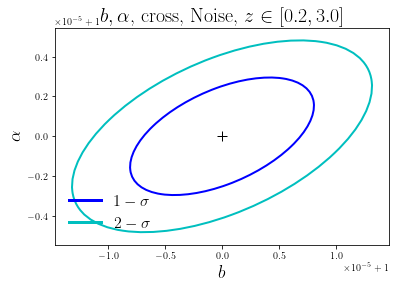

In [14]:
plt.figure()
a,b,theta = ellipse_pars2(sigma_crazy[[0,1],:][:,[0,1]])
plt.figure()
ax = plt.gca()

ellipse1 = Ellipse(xy=(1,1), width=2*1.52*np.sqrt(a), height=2*1.52*np.sqrt(b), angle=theta*180/np.pi,
                        edgecolor='b', fc='None', lw=2)
ax.add_patch(ellipse1)
ellipse2 = Ellipse(xy=(1,1), width=2*2.48*np.sqrt(a), height=2*2.48*np.sqrt(b), angle=theta*180/np.pi,
                        edgecolor='c', fc='None', lw=2)
ax.add_patch(ellipse2)

plt.xlabel(r'$b$',fontsize=18)
plt.ylabel(r'$\alpha$',fontsize=18)
plt.plot(1,1,'k+',ms=10)
#plt.xlim(0.98,1.02)
#plt.ylim(0.98,1.02)
import matplotlib.lines as mlines
eps_line=[]

colours = ['b','c']
sig_labels=[r'$1-\sigma$',r'$2-\sigma$']
for i in range(2):
    eps_line.append(mlines.Line2D([], [], color=colours[i],label=sig_labels[i],linestyle='-',lw=3))

plt.legend(handles=eps_line[:],loc=3,frameon=False,fontsize=16,ncol=1)
plt.title(r'$b,\alpha$, cross, Noise, $z\in[0.2,3.0]$',fontsize=20)


Text(0.5, 1.0, '$s_c,s_d$, cross, Noise, $z\\in[0.2,3.0]$')

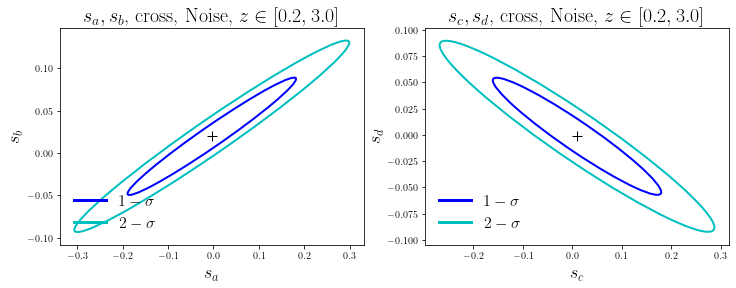

<Figure size 432x288 with 0 Axes>

In [15]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
a,b,theta = ellipse_pars2(sigma_crazy[[2,3],:][:,[2,3]])
plt.figure()
#ax = plt.gca()

ellipse1 = Ellipse(xy=(-3.77e-3,1.97e-2), width=2*1.52*np.sqrt(a), height=2*1.52*np.sqrt(b), angle=theta*180/np.pi,
                        edgecolor='b', fc='None', lw=2)
ax[0].add_patch(ellipse1)
ellipse2 = Ellipse(xy=(-3.77e-3,1.97e-2), width=2*2.48*np.sqrt(a), height=2*2.48*np.sqrt(b), angle=theta*180/np.pi,
                        edgecolor='c', fc='None', lw=2)
ax[0].add_patch(ellipse2)

ax[0].set_xlabel(r'$s_a$',fontsize=18)
ax[0].set_ylabel(r'$s_b$',fontsize=18)
ax[0].plot(-3.77e-3,1.97e-2,'k+',ms=10)
#plt.xlim(0.98,1.02)
#plt.ylim(0.98,1.02)
import matplotlib.lines as mlines
eps_line=[]

colours = ['b','c']
sig_labels=[r'$1-\sigma$',r'$2-\sigma$']
for i in range(2):
    eps_line.append(mlines.Line2D([], [], color=colours[i],label=sig_labels[i],linestyle='-',lw=3))

a,b,theta = ellipse_pars2(sigma_crazy[[4,5],:][:,[4,5]])
ellipse1 = Ellipse(xy=(9.43e-3,-1.34e-3), width=2*1.52*np.sqrt(a), height=2*1.52*np.sqrt(b), angle=theta*180/np.pi,
                        edgecolor='b', fc='None', lw=2)
ax[1].add_patch(ellipse1)
ellipse2 = Ellipse(xy=(9.43e-3,-1.34e-3), width=2*2.48*np.sqrt(a), height=2*2.48*np.sqrt(b), angle=theta*180/np.pi,
                        edgecolor='c', fc='None', lw=2)
ax[1].add_patch(ellipse2)

ax[0].legend(handles=eps_line[:],loc=3,frameon=False,fontsize=16,ncol=1)
ax[0].set_title(r'$s_a,s_b$, cross, Noise, $z\in[0.2,3.0]$',fontsize=20)

ax[1].set_xlabel(r'$s_c$',fontsize=18)
ax[1].set_ylabel(r'$s_d$',fontsize=18)
ax[1].plot(9.43e-3,-1.34e-3,'k+',ms=10)
#plt.xlim(0.98,1.02)
#plt.ylim(0.98,1.02)
import matplotlib.lines as mlines
eps_line=[]

colours = ['b','c']
sig_labels=[r'$1-\sigma$',r'$2-\sigma$']
for i in range(2):
    eps_line.append(mlines.Line2D([], [], color=colours[i],label=sig_labels[i],linestyle='-',lw=3))

ax[1].legend(handles=eps_line[:],loc=3,frameon=False,fontsize=16,ncol=1)
ax[1].set_title(r'$s_c,s_d$, cross, Noise, $z\in[0.2,3.0]$',fontsize=20)
#plt.tight_layout()

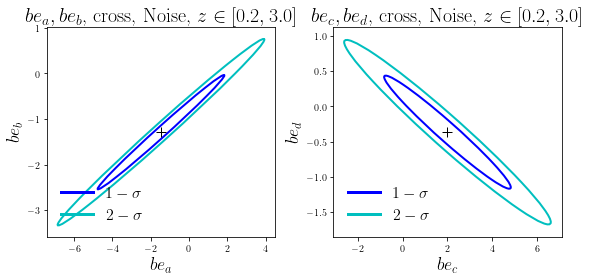

In [16]:
fig, ax = plt.subplots(1,2,figsize=(8,4))

a,b,theta = ellipse_pars2(sigma_crazy[[6,7],:][:,[6,7]])
ellipse1 = Ellipse(xy=(-1.46,-1.29), width=2*1.52*np.sqrt(a), height=2*1.52*np.sqrt(b), angle=theta*180/np.pi,
                        edgecolor='b', fc='None', lw=2)
ax[0].add_patch(ellipse1)
ellipse2 = Ellipse(xy=(-1.46,-1.29), width=2*2.48*np.sqrt(a), height=2*2.48*np.sqrt(b), angle=theta*180/np.pi,
                        edgecolor='c', fc='None', lw=2)
ax[0].add_patch(ellipse2)

ax[0].set_xlabel(r'$be_a$',fontsize=18)
ax[0].set_ylabel(r'$be_b$',fontsize=18)
ax[0].plot(-1.46,-1.29,'k+',ms=10)
#plt.xlim(0.98,1.02)
#plt.ylim(0.98,1.02)
import matplotlib.lines as mlines
eps_line=[]

colours = ['b','c']
sig_labels=[r'$1-\sigma$',r'$2-\sigma$']
for i in range(2):
    eps_line.append(mlines.Line2D([], [], color=colours[i],label=sig_labels[i],linestyle='-',lw=3))

ax[0].legend(handles=eps_line[:],loc=3,frameon=False,fontsize=16,ncol=1)
ax[0].set_title(r'$be_a,be_b$, cross, Noise, $z\in[0.2,3.0]$',fontsize=20)

b,theta = ellipse_pars2(sigma_crazy[[8,9],:][:,[8,9]])
ellipse1 = Ellipse(xy=(2.00,-3.66e-1), width=2*1.52*np.sqrt(a), height=2*1.52*np.sqrt(b), angle=theta*180/np.pi,
                        edgecolor='b', fc='None', lw=2)
ax[1].add_patch(ellipse1)
ellipse2 = Ellipse(xy=(2.00,-3.66e-1), width=2*2.48*np.sqrt(a), height=2*2.48*np.sqrt(b), angle=theta*180/np.pi,
                        edgecolor='c', fc='None', lw=2)
ax[1].add_patch(ellipse2)
ax[1].set_xlabel(r'$be_c$',fontsize=18)
ax[1].set_ylabel(r'$be_d$',fontsize=18)
ax[1].plot(2.00,-3.66e-1,'k+',ms=10)
#plt.xlim(0.98,1.02)
#plt.ylim(0.98,1.02)
import matplotlib.lines as mlines
eps_line=[]

colours = ['b','c']
sig_labels=[r'$1-\sigma$',r'$2-\sigma$']
for i in range(2):
    eps_line.append(mlines.Line2D([], [], color=colours[i],label=sig_labels[i],linestyle='-',lw=3))

ax[1].legend(handles=eps_line[:],loc=3,frameon=False,fontsize=16,ncol=1)
ax[1].set_title(r'$be_c,be_d$, cross, Noise, $z\in[0.2,3.0]$',fontsize=20)
plt.tight_layout()